In [4]:
!pip install plotly

  Using cached plotly-5.7.0-py2.py3-none-any.whl (28.8 MB)


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
pd.options.display.float_format = '{:.4f}'.format


def get_row(n_total, n_cols) :
    if n_total % n_cols == 0 :
        n_rows = n_total / n_cols
    else :
        n_rows = (n_total // n_cols) + 1
    return int(n_rows)
def visualize_articles(articles , article_list, n_total , n_cols , figsize=(25,10)) :
    n_rows = get_row(n_total , n_cols)
    f, ax = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = ax.flatten()
    i = 0
    for article in article_list:
        visualize_article(axes , i , articles , article)
        i += 1
    else :
        plt.show()
        
def visualize_article(axes,i, articles , article) :
    desc = articles[articles['article_id'] == article]['detail_desc'].iloc[0]
    desc_list = desc.split(' ')
    for j, elem in enumerate(desc_list):
        if j > 0 and j % 5 == 0:
            desc_list[j] = desc_list[j] + '\n'
    desc = ' '.join(desc_list)
    try :
        img = mpimg.imread(f'../../data/01_input/images/all/0{int(article)}.jpg')
        axes[i].imshow(img)
    except :
        pass
    axes[i].set_xticks([], [])
    axes[i].set_yticks([], [])
    axes[i].set_title(article)
    axes[i].grid(False)
    axes[i].set_xlabel(desc, fontsize=10)
    
data_submission_path = "gs://01_raw_data/sample_submission.csv"
data_article_path = "gs://01_raw_data/articles.csv"
data_transaction_path = "gs://01_raw_data/transactions_train.csv"
data_customer_path = "gs://01_raw_data/customers.csv"


In [4]:
data_submission_path = "../../data/01_raw/sample_submission.csv"
data_article_path = "../../data/01_raw/articles.csv"
data_transaction_path = "../../data/01_raw/transactions_train.csv"
data_customer_path = "../../data/01_raw/customers.csv"

In [5]:
pd.read_csv(data_article_path,nrows=1).T

,0
article_id,108775015
product_code,108775
prod_name,Strap top
product_type_no,253
product_type_name,Vest top
product_group_name,Garment Upper body
graphical_appearance_no,1010016
graphical_appearance_name,Solid
colour_group_code,9
colour_group_name,Black


# Text Preprocessing

In [8]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 749.7/749.7 KB 28.0 MB/s eta 0:00:00


In [6]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adembek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string 
import numpy as np

def remove_punctuation(text):
    if text != text :
        punctuationfree = ""
    else :
        punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

def tokenization(text):
    tokens = re.split('W+',text)
    return tokens

def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

def stemming(text):
    stem_text = [porter_stemmer.stem(word) for word in text]
    return stem_text

def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

porter_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

In [42]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [43]:
articles = pd.read_csv(data_article_path, dtype={'article_id':str})

In [44]:
articles.head(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [45]:
articles['detail_desc_raw']= articles['detail_desc']


In [46]:
articles['detail_desc']= articles['detail_desc'].apply(lambda x:remove_punctuation(x))
articles['detail_desc'].head()

0                                                                                                                                                                                                      Jersey top with narrow shoulder straps
1                                                                                                                                                                                                      Jersey top with narrow shoulder straps
2                                                                                                                                                                                                      Jersey top with narrow shoulder straps
3    Microfibre Tshirt bra with underwired moulded lightly padded cups that shape the bust and provide good support Narrow adjustable shoulder straps and a narrow hookandeye fastening at the back Without visible seams for greater comfort
4    Microfibre Tshirt bra with underwired mould

In [47]:
articles['detail_desc']= articles['detail_desc'].apply(lambda x: x.lower())
articles['detail_desc'].head()

0                                                                                                                                                                                                      jersey top with narrow shoulder straps
1                                                                                                                                                                                                      jersey top with narrow shoulder straps
2                                                                                                                                                                                                      jersey top with narrow shoulder straps
3    microfibre tshirt bra with underwired moulded lightly padded cups that shape the bust and provide good support narrow adjustable shoulder straps and a narrow hookandeye fastening at the back without visible seams for greater comfort
4    microfibre tshirt bra with underwired mould

In [48]:
articles['detail_desc']= articles['detail_desc'].apply(lambda x: tokenization(x))
articles['detail_desc'].head()

0                                                                                                                                                                                                      [jersey top with narrow shoulder straps]
1                                                                                                                                                                                                      [jersey top with narrow shoulder straps]
2                                                                                                                                                                                                      [jersey top with narrow shoulder straps]
3    [microfibre tshirt bra with underwired moulded lightly padded cups that shape the bust and provide good support narrow adjustable shoulder straps and a narrow hookandeye fastening at the back without visible seams for greater comfort]
4    [microfibre tshirt bra with underwi

In [49]:
articles['detail_desc']= articles['detail_desc'].apply(lambda x: remove_stopwords(x))
articles['detail_desc'].head()

0                                                                                                                                                                                                      [jersey top with narrow shoulder straps]
1                                                                                                                                                                                                      [jersey top with narrow shoulder straps]
2                                                                                                                                                                                                      [jersey top with narrow shoulder straps]
3    [microfibre tshirt bra with underwired moulded lightly padded cups that shape the bust and provide good support narrow adjustable shoulder straps and a narrow hookandeye fastening at the back without visible seams for greater comfort]
4    [microfibre tshirt bra with underwi

In [61]:
articles['detail_desc']= articles['detail_desc'].apply(lambda x: stemming(x))
articles['detail_desc'].head()

0                                                                                                                                                                         [jersey, top, narrow, shoulder, strap]
1                                                                                                                                                                         [jersey, top, narrow, shoulder, strap]
2                                                                                                                                                                         [jersey, top, narrow, shoulder, strap]
3    [microfibr, tshirt, bra, underwir, mould, lightli, pad, cup, shape, bust, provid, good, support, narrow, adjust, shoulder, strap, narrow, hookandey, fasten, back, without, visibl, seam, greater, comfort]
4    [microfibr, tshirt, bra, underwir, mould, lightli, pad, cup, shape, bust, provid, good, support, narrow, adjust, shoulder, strap, narrow, hookandey, fasten, ba

In [51]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/adembek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [52]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /Users/adembek/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [62]:
articles['detail_desc']= articles['detail_desc'].apply(lambda x: lemmatizer(x))
articles['detail_desc'].head()

0                                                                                                                                                                         [jersey, top, narrow, shoulder, strap]
1                                                                                                                                                                         [jersey, top, narrow, shoulder, strap]
2                                                                                                                                                                         [jersey, top, narrow, shoulder, strap]
3    [microfibr, tshirt, bra, underwir, mould, lightli, pad, cup, shape, bust, provid, good, support, narrow, adjust, shoulder, strap, narrow, hookandey, fasten, back, without, visibl, seam, greater, comfort]
4    [microfibr, tshirt, bra, underwir, mould, lightli, pad, cup, shape, bust, provid, good, support, narrow, adjust, shoulder, strap, narrow, hookandey, fasten, ba

In [54]:
articles['detail_desc'] = articles['detail_desc'].apply(lambda x : x[0].split(" "))

In [58]:
articles['detail_desc']= articles['detail_desc'].apply(lambda x: remove_stopwords(x))
articles['detail_desc'].head()

0                                                                                                                                                                                              [jersey, top, narrow, shoulder, strap]
1                                                                                                                                                                                              [jersey, top, narrow, shoulder, strap]
2                                                                                                                                                                                              [jersey, top, narrow, shoulder, strap]
3    [microfibre, tshirt, bra, underwired, moulded, lightly, padded, cups, shape, bust, provide, good, support, narrow, adjustable, shoulder, straps, narrow, hookandeye, fastening, back, without, visible, seams, greater, comfort]
4    [microfibre, tshirt, bra, underwired, moulded, lightly, padded, cups, shape

In [59]:
articles_name = articles.filter(regex="name$|detail")
articles_name.head()

,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,detail_desc_raw
0,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,"[jersey, top, narrow, shoulder, strap]",Jersey top with narrow shoulder straps.
1,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,"[jersey, top, narrow, shoulder, strap]",Jersey top with narrow shoulder straps.
2,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,"[jersey, top, narrow, shoulder, strap]",Jersey top with narrow shoulder straps.
3,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","[microfibre, tshirt, bra, underwired, moulded, lightly, padded, cups, shape, bust, provide, good, support, narrow, adjustable, shoulder, straps, narrow, hookandeye, fastening, back, without, visible, seams, greater, comfort]","Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort."
4,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","[microfibre, tshirt, bra, underwired, moulded, lightly, padded, cups, shape, bust, provide, good, support, narrow, adjustable, shoulder, straps, narrow, hookandeye, fastening, back, without, visible, seams, greater, comfort]","Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort."


In [63]:
pd.set_option('display.max_colwidth', None)
articles_name[['detail_desc_raw', 'detail_desc']].drop_duplicates('detail_desc_raw').head(30)

,detail_desc_raw,detail_desc
0,Jersey top with narrow shoulder straps.,"[jersey, top, narrow, shoulder, strap]"
3,"Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.","[microfibre, tshirt, bra, underwired, moulded, lightly, padded, cups, shape, bust, provide, good, support, narrow, adjustable, shoulder, straps, narrow, hookandeye, fastening, back, without, visible, seams, greater, comfort]"
6,"Semi shiny nylon stockings with a wide, reinforced trim at the top. Use with a suspender belt. 20 denier.","[semi, shiny, nylon, stockings, wide, reinforced, trim, top, use, suspender, belt, 20, deni]"
8,Tights with built-in support to lift the bottom. Black in 30 denier and light amber in 15 denier.,"[tights, builtin, support, lift, bottom, black, 30, denier, light, amber, 15, deni]"
9,"Semi shiny tights that shape the tummy, thighs and calves while also encouraging blood circulation in the legs. Elasticated waist.","[semi, shiny, tights, shape, tummy, thighs, calves, also, encouraging, blood, circulation, legs, elasticated, waist]"
10,Opaque matt tights. 200 denier.,"[opaque, matt, tights, 200, deni]"
11,Sweatshirt in soft organic cotton with a press-stud on one shoulder (sizes 12-18 months and 18-24 months without a press-stud). Brushed inside.,"[sweatshirt, soft, organic, cotton, , pressstud, one, shoulder, sizes, 1218, months, 1824, months, without, pressstud, brushed, insid]"
13,Two soft bandeau bras in soft jersey with side support and a silicone trim at the top.,"[two, soft, bandeau, bras, soft, jersey, side, support, silicone, trim, top]"
15,Fitted top in soft stretch jersey with a wide neckline and long sleeves.,"[fitted, top, soft, stretch, jersey, wide, neckline, long, sleev]"
16,"Trousers in sweatshirt fabric with an elasticated drawstring waist, side pockets, a back pocket and ribbed hems. Soft brushed inside.","[trousers, sweatshirt, fabric, elasticated, drawstring, waist, side, pockets, back, pocket, ribbed, hems, soft, brushed, insid]"


In [67]:
def get_list(x) :
    total_info = []
    for i in x.values.tolist() :
        if isinstance( i , (str,)) :
            total_info.append(i)
        elif isinstance( i , (list,)) :
            total_info.extend(i)
    else :
        return total_info

articles_name_list = articles_name.drop('detail_desc_raw', axis=1).apply(lambda x : get_list(x), axis=1)

In [72]:
articles_name.drop('detail_desc_raw', axis=1).head(11)

,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc
0,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,"[jersey, top, narrow, shoulder, strap]"
1,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,"[jersey, top, narrow, shoulder, strap]"
2,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,"[jersey, top, narrow, shoulder, strap]"
3,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","[microfibre, tshirt, bra, underwired, moulded, lightly, padded, cups, shape, bust, provide, good, support, narrow, adjustable, shoulder, straps, narrow, hookandeye, fastening, back, without, visible, seams, greater, comfort]"
4,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","[microfibre, tshirt, bra, underwired, moulded, lightly, padded, cups, shape, bust, provide, good, support, narrow, adjustable, shoulder, straps, narrow, hookandeye, fastening, back, without, visible, seams, greater, comfort]"
5,OP T-shirt (Idro),Bra,Underwear,Solid,Light Beige,Dusty Light,Beige,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","[microfibre, tshirt, bra, underwired, moulded, lightly, padded, cups, shape, bust, provide, good, support, narrow, adjustable, shoulder, straps, narrow, hookandeye, fastening, back, without, visible, seams, greater, comfort]"
6,20 den 1p Stockings,Underwear Tights,Socks & Tights,Solid,Black,Dark,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,"[semi, shiny, nylon, stockings, wide, reinforced, trim, top, use, suspender, belt, 20, deni]"
7,20 den 1p Stockings,Socks,Socks & Tights,Solid,Beige,Medium Dusty,Beige,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,"[semi, shiny, nylon, stockings, wide, reinforced, trim, top, use, suspender, belt, 20, deni]"
8,Shape Up 30 den 1p Tights,Leggings/Tights,Garment Lower body,Solid,Black,Dark,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,"[tights, builtin, support, lift, bottom, black, 30, denier, light, amber, 15, deni]"
9,Support 40 den 1p Tights,Underwear Tights,Socks & Tights,Solid,Black,Dark,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,"[semi, shiny, tights, shape, tummy, thighs, calves, also, encouraging, blood, circulation, legs, elasticated, waist]"


In [68]:
articles_name_list[10]

['200 den 1p Tights',
 'Underwear Tights',
 'Socks & Tights',
 'Solid',
 'Black',
 'Dark',
 'Black',
 'Tights basic',
 'Lingeries/Tights',
 'Ladieswear',
 'Womens Nightwear, Socks & Tigh',
 'Socks and Tights',
 'opaque',
 'matt',
 'tights',
 '200',
 'deni']

# Word2Vec

In [40]:
# from gensim.models import Word2Vec
# model = Word2Vec(sentences=articles_name_list, vector_size=50, window=5, min_count=1, workers=4)
# model.save("word2vec.model")
# sims = model.wv.most_similar('Black', topn=10) 
# sims

# Setence-Transformer

In [41]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 KB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 45.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 998.6 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 16.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.6 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 58.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 60.6 MB/s eta 0:00:00:00:0100:01
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=8eae050515011ae4dfc8e1bee005641651977abd142ff465be95929faf0e54d7
  Stored in directory: /home/jupyter/.cache/pip/

In [43]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

## Embedding

In [44]:
sentence_embeddings  = sbert_model.encode(" ".join(articles_name_list[0]))
sentence_embeddings.shape

(768,)

In [84]:
article_sentences = [" ".join(article) for article in articles_name_list]

## Save

In [86]:
%%time
print('Estimating SBERT model...')
result = sbert_model.encode(article_sentences, device='cuda')
print('Finished!')

Estimating SBERT model...
Finished!
CPU times: user 10min 56s, sys: 3min 34s, total: 14min 31s
Wall time: 13min 48s


In [138]:
result_df = pd.DataFrame(result,
                         columns=['txt_emb_' + str(i) for i in range(1, result.shape[1]+1)],
                         index=articles.article_id)

print(result_df.shape)
result_df.head()

(105542, 768)


,txt_emb_1,txt_emb_2,txt_emb_3,txt_emb_4,txt_emb_5,txt_emb_6,txt_emb_7,txt_emb_8,txt_emb_9,txt_emb_10,...,txt_emb_759,txt_emb_760,txt_emb_761,txt_emb_762,txt_emb_763,txt_emb_764,txt_emb_765,txt_emb_766,txt_emb_767,txt_emb_768
article_id,,,,,,,,,,,,,,,,,,,,,
0108775015,0.0628,-0.7912,-1.4413,0.2822,1.0979,0.1608,0.5902,-0.2243,0.1721,-0.0134,...,-0.2243,-1.0458,0.1852,-0.3517,-0.4217,-1.6555,-0.3742,-0.2580,-0.1635,-0.5014
0108775044,0.0835,-0.6256,-1.5017,0.4354,0.7590,-0.8283,0.9023,-0.4051,0.5698,-0.4322,...,-0.2637,-1.5589,-0.1984,-0.4196,-0.1783,-1.0269,-0.3763,0.3162,-0.0308,-0.1626
0108775051,0.0131,-0.9510,-1.4900,0.3991,0.8189,-0.5114,0.7476,-0.5131,0.5527,-0.3791,...,-0.2119,-1.4542,-0.2269,-0.2972,-0.0293,-1.3812,-0.5269,0.2259,0.0449,-0.3212
0110065001,-0.2806,-0.4909,-1.1498,0.4363,0.7308,0.1694,0.8061,-0.5649,0.4019,0.3521,...,-0.4845,-1.3734,-0.4741,-0.8362,-0.3189,-1.1961,0.3509,-0.6094,-0.5438,-0.0692
0110065002,-0.3837,-0.3370,-1.0104,0.4879,0.5459,-0.2482,0.9178,-0.7390,0.5327,0.1452,...,-0.4815,-1.6253,-0.5473,-0.8726,-0.2286,-0.8505,0.3236,-0.3725,-0.5378,0.1068


In [148]:
embedding_path = "../../data/06a_text_embeddings/text_embeddings.npy"
embedding_df_path = "gs://06a_text_embeddings/text_embeddings.parquet"

In [149]:
np.save(embedding_path, result)

In [150]:
result_df.to_parquet(embedding_df_path)

In [95]:
np.load(embedding_path).shape

(105542, 768)

Download

In [96]:
from IPython.display import FileLink
import os
os.chdir(r'../../data/06a_text_embeddings')
FileLink(r'embedding.npy')

/home/jupyter/aa_team_kagle_hm/data/06a_text_embeddings/embedding.npy

MY GOOGLE DRIVE LINK

https://drive.google.com/file/d/1AAI8Bws_9rustIWPoCvz9I3rC7GLsI4J/view?usp=sharing


## Load

In [97]:
import numpy as np

embedding_vector = np.load(embedding_path)

In [98]:
from tqdm import tqdm

# Cosine Similarity

In [99]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(embedding_vector,idx) :
    
    embedding_cosine = cosine_similarity(embedding_vector[[idx],] , embedding_vector)
    embedding_cosine[0,idx]=0
    return embedding_cosine[0]


def get_best_similiarity(embedding_vector,idx, best_n = 3) :
    emb_cosine = get_cosine_similarity(embedding_vector , idx)
    return emb_cosine.argsort()[-best_n:][::-1]


In [100]:
articles = pd.read_csv(data_article_path, dtype={'article_id':str})

In [101]:
check_idx = 0
top_articles = get_best_similiarity(embedding_vector , check_idx , best_n=5)

# Cosine Similarity (top 6)

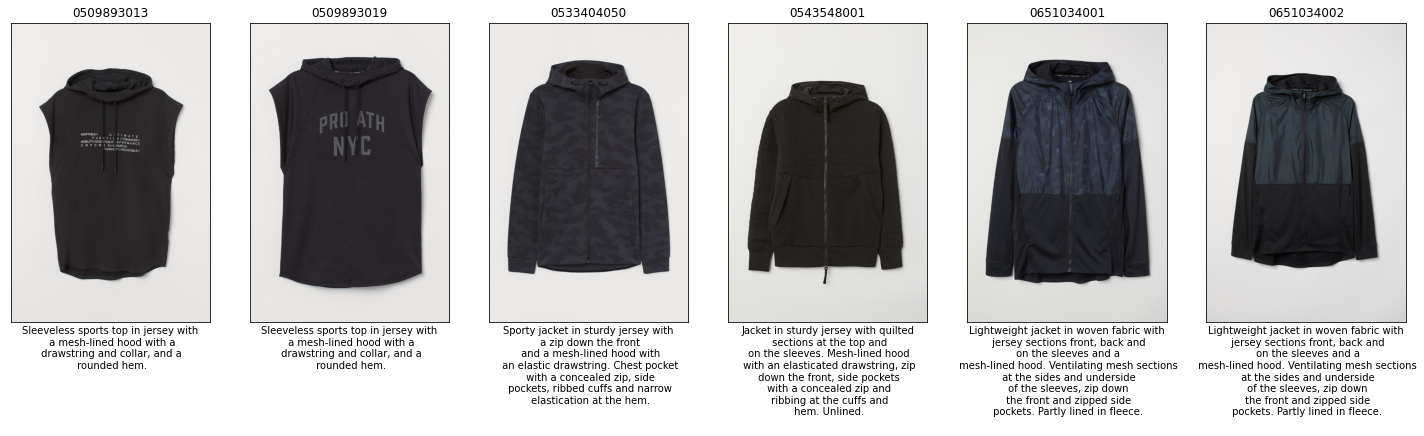

In [151]:
best_articles = articles[articles.index.isin([check_idx] + top_articles.tolist())]
visualize_articles(articles, best_articles['article_id'].values.tolist() ,n_total = len(best_articles) ,n_cols=6 )

['0568174017', '0568174037', '0632225002', '0632225007', '0840622002']


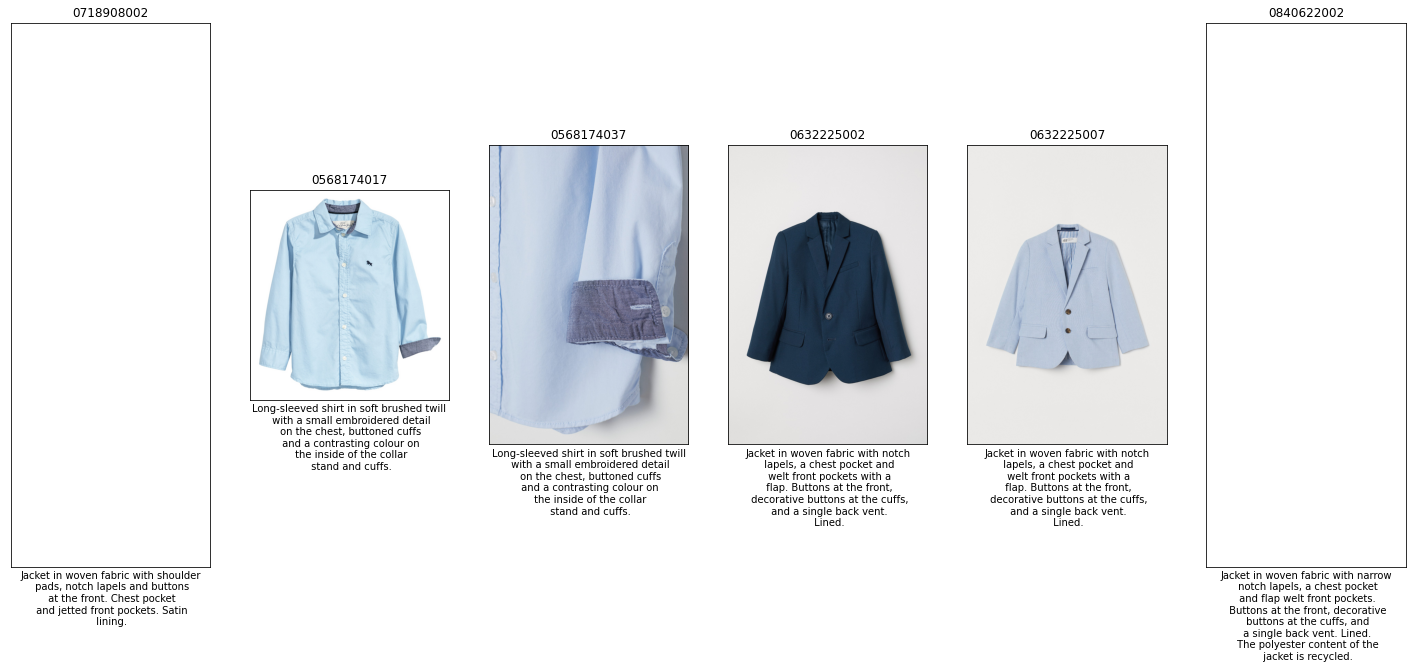

['0806388010', '0806388028', '0825720006', '0863538002', '0880333002']


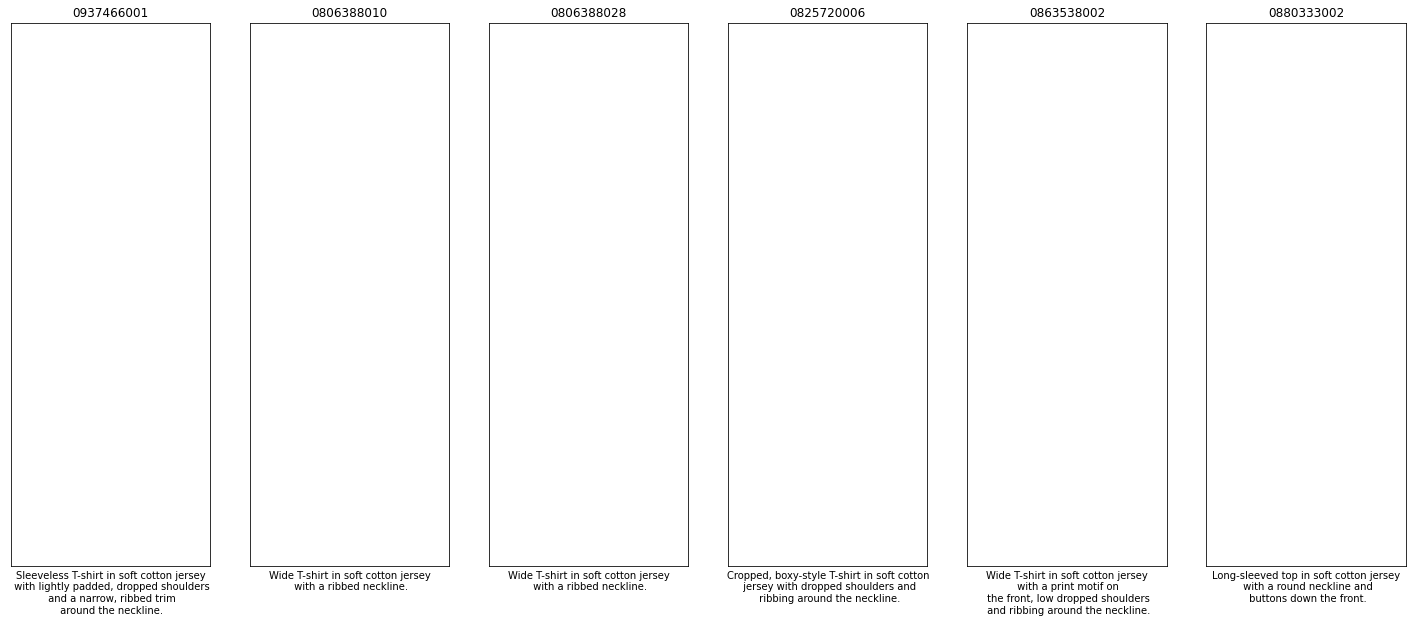

['0590007001', '0661806001', '0874537001', '0886471001', '0904817001']


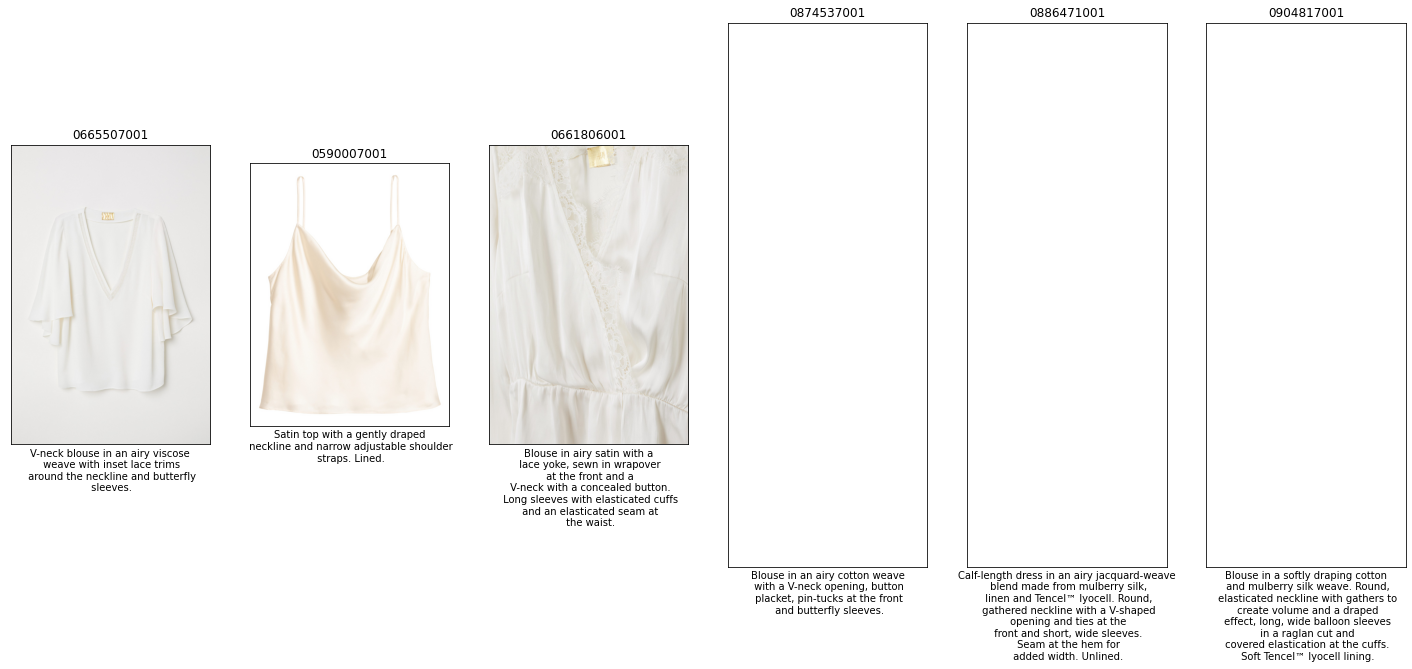

['0497369001', '0657852006', '0704299003', '0755908001', '0772571006']


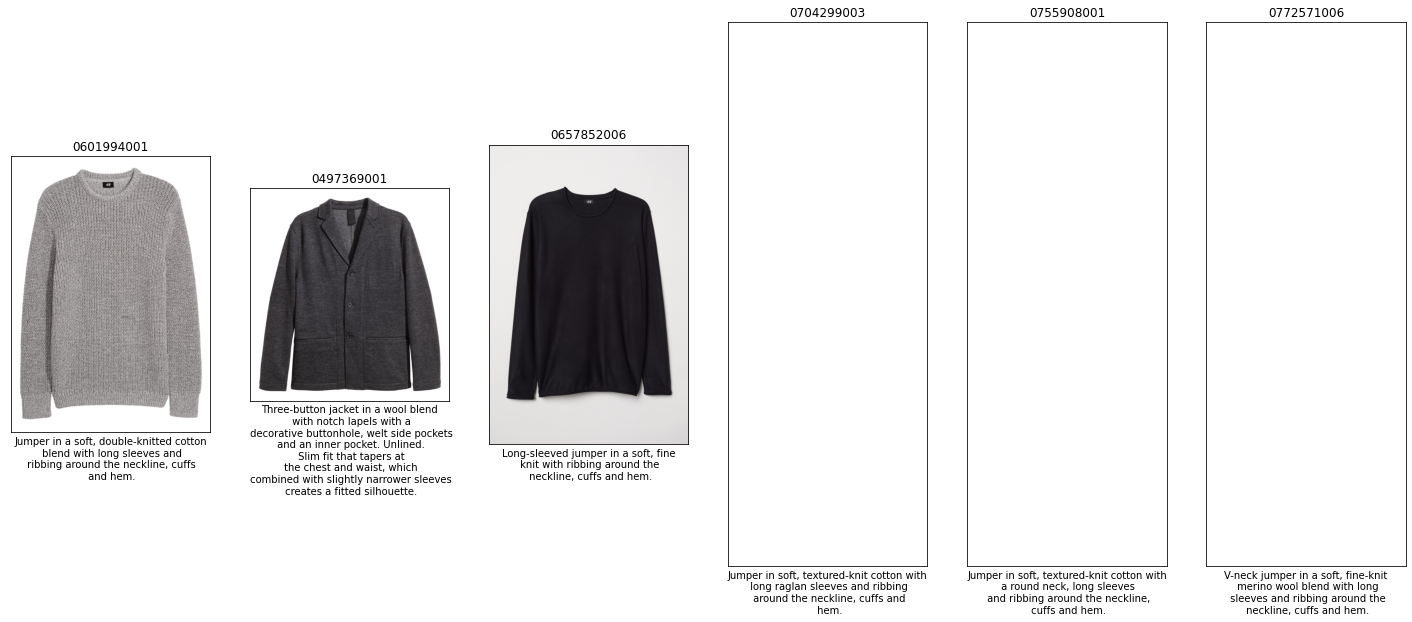

['0509893013', '0509893019', '0533404050', '0543548001', '0651034002']


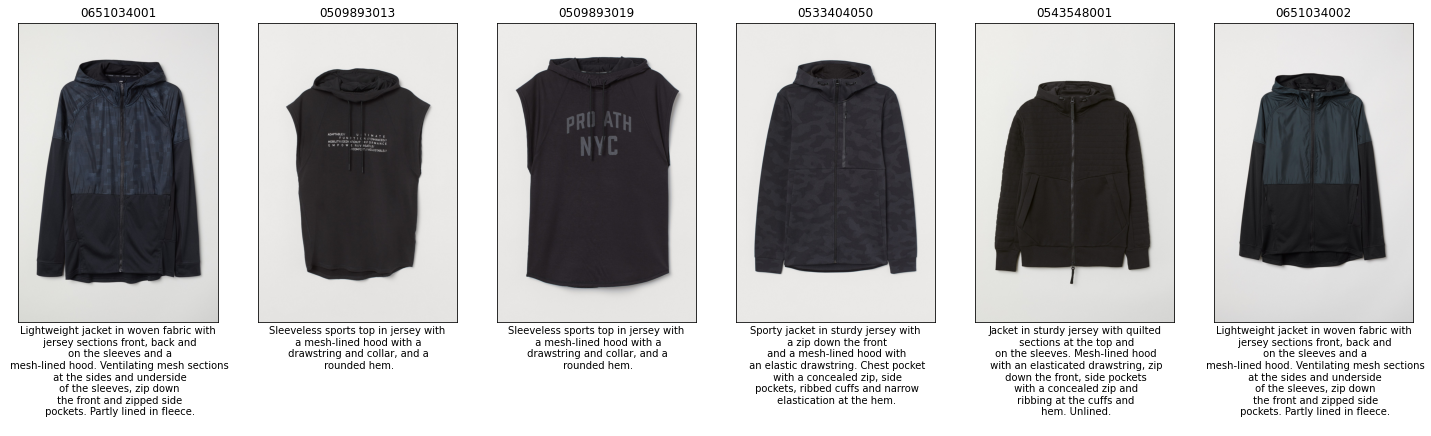

In [152]:
article_candidates = articles.groupby('index_group_name').sample(1).index.tolist()
article_candidates = [58100, 105333, 40738, 23079, 36520]
for check_idx in article_candidates :
    top_articles = get_best_similiarity(embedding_vector , check_idx , best_n=5)
    best_articles = articles[articles.index.isin(top_articles.tolist())]
    print(best_articles["article_id"].tolist())

    criterion = articles.iloc[check_idx,]['article_id']

    visualize_articles(articles, [criterion] + best_articles['article_id'].values.tolist() ,n_total = len(best_articles) ,n_cols=6 )

In [107]:
!pip install umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=d6d9f89cf5c1554e554e2a23406d0d1b44c3656873ff18ea433ec0909e1fef7d
  Stored in directory: /home/jupyter/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=94a9a50be3bf98e5b669aeb5c68771d0ac107b590c95f81c306f8c58b73991c4
  

# UMAP 

In [108]:
import umap

In [113]:
mapper = umap.UMAP().fit(embedding_vector)

In [114]:
import joblib
filename = '../../data/06a_text_embeddings/umap_mapper.sav'
joblib.dump(mapper, filename)

/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


['../../data/06a_text_embeddings/umap_mapper.sav']

In [115]:
from IPython.display import FileLink
import os
os.chdir(r'../../data/06a_text_embeddings')
FileLink(r'umap_mapper.sav')

/home/jupyter/aa_team_kagle_hm/data/06a_text_embeddings/umap_mapper.sav

In [116]:
import joblib
filename = '../../data/06a_text_embeddings/umap_mapper.sav'
mapper = joblib.load(filename)


In [117]:
articles.filter(regex="name$")

,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name
0,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
1,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
2,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
3,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"
4,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"
...,...,...,...,...,...,...,...,...,...,...,...,...
105537,5pk regular Placement1,Socks,Socks & Tights,Placement print,Black,Dark,Black,Socks Bin,Menswear,Menswear,Men Underwear,Socks and Tights
105538,SPORT Malaga tank,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey,Ladieswear,Ladieswear,H&M+,Jersey Fancy
105539,Cartwheel dress,Dress,Garment Full body,Solid,Black,Dark,Black,Jersey,Ladieswear,Ladieswear,Womens Trend,Jersey Fancy
105540,CLAIRE HAIR CLAW,Hair clip,Accessories,Solid,Black,Dark,Black,Small Accessories,Divided,Divided,Divided Accessories,Accessories


In [118]:
import umap.plot

/opt/conda/lib/python3.7/site-packages/umap/plot.py:29: UserWarning: The umap.plot package requires extra plotting libraries to be installed.
    You can install these via pip using

    pip install umap-learn[plot]

    or via conda using

     conda install pandas matplotlib datashader bokeh holoviews colorcet scikit-image
    
  """


ImportError: umap.plot requires pandas matplotlib datashader bokeh holoviews scikit-image and colorcet to be installed

# UMAP Visualization 2D

In [ ]:
umap.plot.points(mapper, color_key_cmap='Paired', background='black')
plt.show()

In [ ]:
umap.plot.points(mapper, labels=articles.index_group_name, color_key_cmap='Paired', background='black')
plt.show()

In [ ]:
umap.plot.points(mapper, labels=articles.index_name, color_key_cmap='Paired', background='black')
plt.show()